## 03 - Modelling

## Optional - Colab Setup

In [0]:
def upgrade_runtime_ram():
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

In [0]:
def restart_runtime():
    os.kill(os.getpid(), 9)

In [0]:
def setup_rapids():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13


    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [0]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [0]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [111]:
try:
    import sys,os,subprocess
    
    upgrade_runtime_ram()
    setup_drive()

    #Setting up PyPi Packages
    !pip install geopandas sparse-dot-topn pdpipe category-encoders catboost
    import geopandas as gpd
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp
    import category_encoders

    #Setting up Conda Packages
    setup_conda()
    
    #Initializing NLTK
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    
    #Setting up RAPIDS AI
    import pynvml
    setup_rapids()
    
    from cuml import UMAP
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')
    from umap import UMAP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - failed

ResolvePackageNotFound: 
  - libpq==12.2=h554dc5a_0
  - llvm-openmp==9.0.1=h28b9765_2
  - libgdal==3.0.4=hec54991_3
  - sparse_dot_topn==0.2.9=py36h863e41a_0
  - xz==5.2.4=h0b31af3_1002
  - giflib==5.2.1=h0b31af3_2
  - sqlite==3.30.1=h93121df_0
  - xerces-c==3.2.2=h8f8adb3_1004

## Imports

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split,  StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tqdm.pandas()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [0]:
from lib.transformers import *
from lib.pipelines import *
from lib.processing import save_to_pkl, load_from_pkl
from lib.visualization import GridSearchPlotter
from data.util.paths import DATA_PATH

In [0]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [0]:
from cuml import LinearRegression, RandomForestRegressor, Ridge, Lasso

In [0]:
from catboost import CatBoostRegressor

## Loading Data

In [0]:
metadata_df, image_embeddings_df = tuple(load_from_pkl(i,DATA_PATH) for i in ('metadata','image_embeddings'))
df = metadata_df.merge(image_embeddings_df,how='inner',on='release_id')
df = OutlierRemover(features=['number_of_tracks'] + [i for i in df.columns if 'umap' in i]).fit_transform(df[(df['running_time'] < 180) | (df['running_time'].isna())])

In [0]:
del metadata_df, image_embeddings_df

In [120]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'genre': 'genre_',
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0,
    'image_embedding': 'image_umap_'
}
column_store = ColumnStore()
column_store.fit(df,col_set)

## Preparing for Machine Learning

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(df.drop('market_value',axis=1),df.market_value)

In [0]:
units_for_sale_imputer = SimpleImputer(strategy='constant',fill_value=0)
average_rating_imputer = SimpleImputer(strategy='mean')

In [0]:
X_tr['units_for_sale'] = units_for_sale_imputer.fit_transform(X_tr['units_for_sale'].values.reshape(-1,1))
X_te['units_for_sale'] = units_for_sale_imputer.transform(X_te['units_for_sale'].values.reshape(-1,1))

In [0]:
X_tr['average_rating'] = average_rating_imputer.fit_transform(X_tr['average_rating'].values.reshape(-1,1))
X_te['average_rating'] = average_rating_imputer.transform(X_te['average_rating'].values.reshape(-1,1))

In [0]:
df_sample = pd.concat([X_tr,y_tr],axis=1).sample(frac=0.1)
X_tr_sample = df_sample.drop('market_value',axis=1)
y_tr_sample = df_sample['market_value']

In [0]:
del df

## Setting up Dummy Regression for baseline

In [0]:
dummy_regressor = DummyRegressor(strategy='mean')

In [20]:
dummy_regressor.fit(X_tr,np.log(y_tr).values)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [0]:
dummy_pred = dummy_regressor.predict(X_te)

In [22]:
r2_score(y_te,np.exp(dummy_pred))

-0.07919813158704159

In [23]:
mean_absolute_error(y_te,np.exp(dummy_pred))

10.606333900626483

## Linear Regression - Record Store

In [0]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [0]:
record_store_regression_transformer = ColumnTransformer(transformers=[
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [0]:
record_store_regression_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title', 'release_id'
])

In [0]:
record_store_regression_processing = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(record_store_regression_removal_columns)),
    ('preprocessing',record_store_regression_transformer),
    ('scaler', RobustScaler()),                             
])

record_store_lr_pipe = Pipeline([
    ('processing', record_store_regression_processing),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize': [True, False]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [36]:
record_store_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   16.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.6s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='va...
                              estimator=LinearRegression(algorithm='eig', fit_intercept=Tr

In [37]:
record_store_lr_pipe.steps[-1][-1].best_score_

-0.5340656382173578

In [38]:
record_store_lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [39]:
r2_score(y_te,np.exp(record_store_lr_pred))

-0.5444008840652477

In [40]:
mean_absolute_error(y_te,np.exp(record_store_lr_pred))

8.679495750903042

## Linear Regression - Full Information

In [0]:
full_information_regression_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [0]:
full_information_columns = set([
    'units_for_sale','community_have','community_want','average_rating','rating_count'
])
full_information_regression_removal_columns = record_store_regression_removal_columns - full_information_columns

In [0]:
full_information_regression_processing = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(full_information_regression_removal_columns)),
    ('preprocessing',full_information_regression_transformer),
    ('scaler', RobustScaler()),
])

full_information_lr_pipe = Pipeline([
    ('processing', full_information_regression_processing),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize':[False,True]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [60]:
full_information_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.6s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='va...
                              estimator=LinearRegression(algorithm='eig', fit_intercept=Tr

In [45]:
full_information_lr_pipe['lr'].best_score_

-0.5010604648455177

In [46]:
full_information_lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [47]:
r2_score(y_te,np.exp(full_information_lr_pred))

-0.5444008840652477

In [48]:
mean_absolute_error(y_te,np.exp(full_information_lr_pred))

8.679495750903042

## Ridge Regression - Record Store

In [0]:
record_store_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(record_store_regression_removal_columns)),
    ('preprocessing',record_store_regression_transformer),
    ('scaler', RobustScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.linspace(1e-3,1e3,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [51]:
record_store_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.7s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'format_name', 'master_id'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=Ridge(alpha=1.0, solver='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f692562c370>, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'alpha': array([1.00000e-03, 1.11112e+02, 2.22223e+02, 3.3

In [0]:
plotter = GridSearchPlotter(record_store_ridge_pipe['ridge'])

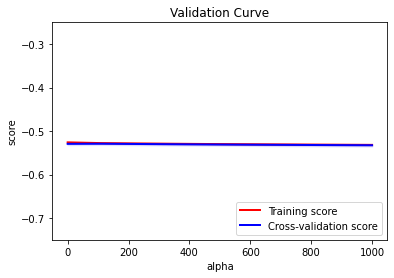

In [53]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [54]:
record_store_ridge_pipe['ridge'].best_score_

-0.52908826482305

In [55]:
record_store_ridge_pipe['ridge'].best_params_

{'alpha': 111.11200000000001}

In [56]:
record_store_ridge_pred = record_store_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [57]:
r2_score(y_te,np.exp(record_store_ridge_pred))

0.15712499880493624

In [58]:
mean_absolute_error(y_te,np.exp(record_store_ridge_pred))

8.52437960713163

## Ridge - Full Information

In [0]:
full_information_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(full_information_regression_removal_columns)),
    ('preprocessing',full_information_regression_transformer),
    ('scaler', StandardScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.logspace(-3,3,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [60]:
full_information_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.1s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'format_name', 'master_id'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=Ridge(alpha=1.0, solver='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f69295553f0>, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469

In [0]:
plotter = GridSearchPlotter(full_information_ridge_pipe['ridge'])

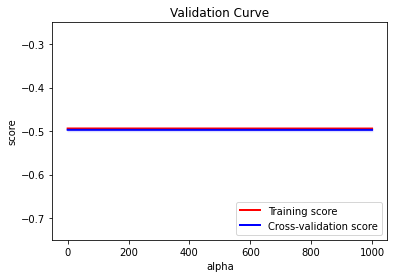

In [62]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [63]:
full_information_ridge_pipe['ridge'].best_score_

-0.49712285887266416

In [64]:
full_information_ridge_pipe['ridge'].best_params_

{'alpha': 46.41588833612773}

In [65]:
full_information_ridge_pred = full_information_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [66]:
r2_score(y_te,np.exp(full_information_ridge_pred))

-25.0720273878473

In [67]:
mean_absolute_error(y_te,np.exp(full_information_ridge_pred))

8.767547014439332

## Random Forest - Record Store

In [0]:
record_store_random_forest_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title','release_id'
]
record_store_random_forest_removal_columns.extend(
    column_store._indicator
)
record_store_random_forest_removal_columns = set(record_store_random_forest_removal_columns)

In [0]:
record_store_random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(record_store_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.values.astype(np.float32)))
])

random_forest = RandomForestRegressor()

record_store_random_forest_search_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

record_store_random_forest_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [70]:
record_store_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample).values.astype(np.float32))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  2.7min remaining:   21.9s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  2.9min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.1min finished


/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                              

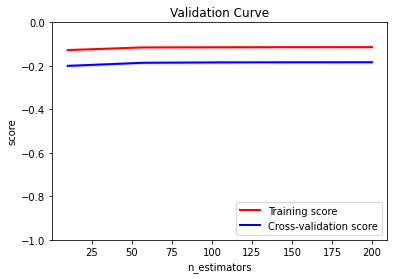

In [71]:
record_store_random_forest_plotter = GridSearchPlotter(record_store_random_forest_search_pipe.steps[-1][1])
record_store_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [72]:
record_store_random_forest_search_pipe.steps[-1][1].best_score_

-0.18297612071037292

In [73]:
record_store_random_forest_search_pipe.steps[-1][1].best_params_

{'n_estimators': 200}

In [74]:
record_store_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                 RandomForestR

In [75]:
record_store_random_forest_te_pred = record_store_random_forest_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [77]:
r2_score(y_te,np.exp(record_store_random_forest_te_pred))

-0.0676287886282958

In [78]:
mean_absolute_error(y_te,np.exp(record_store_random_forest_te_pred))

10.45988818775278

## Random Forest - Full Information

In [0]:
full_information_random_forest_removal_columns = record_store_random_forest_removal_columns - full_information_columns

In [0]:
full_information_random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(full_information_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.astype(np.float32)))
])

full_information_random_forest_search_pipe = Pipeline([
    ('preprocessing',full_information_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

full_information_random_forest_pipe = Pipeline([
    ('preprocessing',full_information_random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [92]:
full_information_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample).values.astype(np.float32))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   25.6s


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  2.1min remaining:   39.0s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  2.6min remaining:   39.1s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  2.9min remaining:   32.6s
[Parallel(n_j

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                              

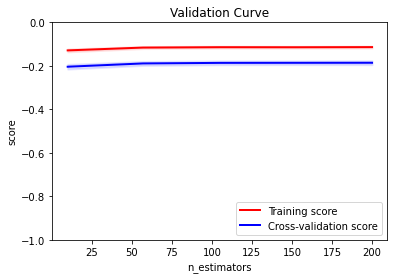

In [98]:
full_information_random_forest_plotter = GridSearchPlotter(full_information_random_forest_search_pipe.steps[-1][1])
full_information_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [94]:
full_information_random_forest_search_pipe.steps[-1][1].best_score_

-0.18541913032531737

In [95]:
full_information_random_forest_search_pipe.steps[-1][1].best_params_

{'n_estimators': 200}

In [96]:
full_information_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                 RandomForestR

In [99]:
full_information_random_forest_te_pred = full_information_random_forest_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [101]:
r2_score(y_te,np.exp(full_information_random_forest_te_pred))

-0.061419817566708446

In [102]:
mean_absolute_error(y_te,np.exp(full_information_random_forest_te_pred))

10.469584254644312

## Catboost - Record Store

In [0]:
record_store_catboost_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title','release_id'
])
record_store_catboost_removal_columns = record_store_catboost_removal_columns.union(column_store._geography_country)

In [0]:
record_store_catboost_processing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('record_store_column_remover', ColumnRemover(record_store_catboost_removal_columns)),
])

catboost = CatBoostRegressor(
    random_seed=0,
    cat_features=['year','format_text','master_id','format_name','artist','label','country'],
    boosting_type='Ordered',
    n_estimators=100,
    learning_rate=0.1,
    l2_leaf_reg=3,
    border_count=170,
    max_depth=10,
)

record_store_catboost_grid_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={
            #'learning_rate': np.logspace(-3,1,5),
            #'border_count': np.linspace(1,200,5),
            'l2_leaf_reg': [1,3,5,8],
        },
        n_jobs=-1,
        cv=KFold(n_splits=5,shuffle=True),
        verbose=1,
        scoring='neg_mean_absolute_error',
        return_train_score=True)
    )
])

record_store_catboost_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('catboost',catboost)
])

In [263]:
record_store_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.8min finished


0:	learn: 0.8745215	total: 272ms	remaining: 26.9s
1:	learn: 0.8572576	total: 505ms	remaining: 24.7s
2:	learn: 0.8421888	total: 735ms	remaining: 23.8s
3:	learn: 0.8304112	total: 976ms	remaining: 23.4s
4:	learn: 0.8198188	total: 1.21s	remaining: 23.1s
5:	learn: 0.8116588	total: 1.33s	remaining: 20.9s
6:	learn: 0.8034607	total: 1.56s	remaining: 20.8s
7:	learn: 0.7950812	total: 1.79s	remaining: 20.6s
8:	learn: 0.7878371	total: 2.03s	remaining: 20.5s
9:	learn: 0.7817310	total: 2.26s	remaining: 20.4s
10:	learn: 0.7766092	total: 2.5s	remaining: 20.2s
11:	learn: 0.7711975	total: 2.72s	remaining: 20s
12:	learn: 0.7675991	total: 2.75s	remaining: 18.4s
13:	learn: 0.7641557	total: 2.99s	remaining: 18.4s
14:	learn: 0.7606503	total: 3.22s	remaining: 18.3s
15:	learn: 0.7573206	total: 3.46s	remaining: 18.2s
16:	learn: 0.7548228	total: 3.69s	remaining: 18s
17:	learn: 0.7516075	total: 3.92s	remaining: 17.9s
18:	learn: 0.7481186	total: 4.16s	remaining: 17.7s
19:	learn: 0.7455433	total: 4.39s	remaining: 1

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'average_rating',
                                                                'community_have',
                                                                'community_want',
                                                                'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'coun...
                          verbose=False)),


In [166]:
record_store_catboost_plot = GridSearchPlotter(record_store_catboost_grid_pipe.steps[-1][1])
record_store_catboost_plot.plot_validation_curve(parameter='border_count',ylim=(-2,1))

ValueError: ignored

In [261]:
record_store_catboost_grid_pipe.steps[-1][1].best_score_

AttributeError: ignored

In [262]:
record_store_catboost_grid_pipe.steps[-1][1].best_params_

AttributeError: ignored

In [246]:
record_store_catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8679615	total: 895ms	remaining: 1m 28s
1:	learn: 0.8485094	total: 1.74s	remaining: 1m 25s
2:	learn: 0.8296594	total: 2.6s	remaining: 1m 24s
3:	learn: 0.8138238	total: 3.45s	remaining: 1m 22s
4:	learn: 0.8001578	total: 4.3s	remaining: 1m 21s
5:	learn: 0.7880159	total: 5.17s	remaining: 1m 21s
6:	learn: 0.7781756	total: 6.01s	remaining: 1m 19s
7:	learn: 0.7699769	total: 6.86s	remaining: 1m 18s
8:	learn: 0.7630904	total: 7.7s	remaining: 1m 17s
9:	learn: 0.7571475	total: 8.54s	remaining: 1m 16s
10:	learn: 0.7484197	total: 9.39s	remaining: 1m 16s
11:	learn: 0.7409245	total: 10.3s	remaining: 1m 15s
12:	learn: 0.7347365	total: 11.1s	remaining: 1m 14s
13:	learn: 0.7293807	total: 12s	remaining: 1m 13s
14:	learn: 0.7247611	total: 12.8s	remaining: 1m 12s
15:	learn: 0.7208361	total: 13.6s	remaining: 1m 11s
16:	learn: 0.7175448	total: 14.5s	remaining: 1m 10s
17:	learn: 0.7144864	total: 15.3s	remaining: 1m 9s
18:	learn: 0.7121725	total: 16.2s	remaining: 1m 8s
19:	learn: 0.7100566	total: 1

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'average_rating',
                                                                'community_have',
                                                                'community_want',
                                                                'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'coun...
                                           

In [0]:
record_store_catboost_te_pred = record_store_catboost_pipe.predict(X_te)

In [250]:
r2_score(y_te,np.exp(record_store_catboost_te_pred))

0.21810112476056465

In [251]:
mean_absolute_error(y_te,np.exp(record_store_catboost_te_pred))

8.088914961140624

## CatBoost - Full Information

In [0]:
full_information_catboost_removal_columns = record_store_catboost_removal_columns - full_information_columns

In [0]:
full_information_catboost_processing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('record_store_column_remover', ColumnRemover(full_information_catboost_removal_columns)),
])

full_information_catboost_grid_pipe = Pipeline([
    ('processing', full_information_catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={            
            #'learning_rate': np.logspace(-3,1,5),
            #'border_count': np.linspace(1,200,5),
            'l2_leaf_reg': [1,3,5,8],
        },
        n_jobs=3,
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=50,
        return_train_score=True)
    )
])

full_information_catboost_pipe = Pipeline([
    ('processing', full_information_catboost_processing_pipe),
    ('catboost',catboost)
])

In [224]:
full_information_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample).values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:  2.3min


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:  6.2min
[Parallel(n_jobs=3)]: Done  16 out of  20 | elapsed:  7.0min remaining:  1.8min
[Parallel(n_jobs=3)]: Done  17 out of  20 | elapsed:  7.1min remaining:  1.3min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  7.4min remaining:   49.1s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  8.0min remaining:    0.0s
[Parallel

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'days_since_last_sale',
                                                                'format_description',
                                                                'formats',
                                                                'genre', 'have',
                                                                'highest',
                                                                'last_sold',
                                                                'lowest',
                                                       

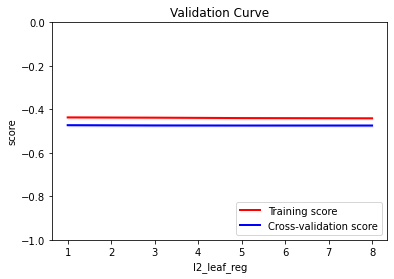

In [226]:
full_information_catboost_plot = GridSearchPlotter(full_information_catboost_grid_pipe.steps[-1][1])
full_information_catboost_plot.plot_validation_curve(parameter='l2_leaf_reg',ylim=(-1,0))

In [227]:
full_information_catboost_grid_pipe.steps[-1][1].best_score_

-0.47239278838420995

In [228]:
full_information_catboost_grid_pipe.steps[-1][1].best_params_

{'l2_leaf_reg': 1}

In [255]:
full_information_catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8566124	total: 902ms	remaining: 1m 29s
1:	learn: 0.8271142	total: 1.77s	remaining: 1m 26s
2:	learn: 0.8021425	total: 2.64s	remaining: 1m 25s
3:	learn: 0.7805040	total: 3.53s	remaining: 1m 24s
4:	learn: 0.7613803	total: 4.41s	remaining: 1m 23s
5:	learn: 0.7458909	total: 5.27s	remaining: 1m 22s
6:	learn: 0.7318959	total: 6.14s	remaining: 1m 21s
7:	learn: 0.7200994	total: 7.01s	remaining: 1m 20s
8:	learn: 0.7086161	total: 7.88s	remaining: 1m 19s
9:	learn: 0.6990736	total: 8.74s	remaining: 1m 18s
10:	learn: 0.6905685	total: 9.61s	remaining: 1m 17s
11:	learn: 0.6831726	total: 10.5s	remaining: 1m 17s
12:	learn: 0.6767884	total: 11.4s	remaining: 1m 16s
13:	learn: 0.6705847	total: 12.2s	remaining: 1m 15s
14:	learn: 0.6653838	total: 13.1s	remaining: 1m 14s
15:	learn: 0.6608367	total: 14s	remaining: 1m 13s
16:	learn: 0.6566962	total: 14.8s	remaining: 1m 12s
17:	learn: 0.6519837	total: 15.7s	remaining: 1m 11s
18:	learn: 0.6482265	total: 16.6s	remaining: 1m 10s
19:	learn: 0.6444558	tot

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'country_angola',
                                                                'country_argentina',
                                                                'country_armenia',
                                                                '...
                                           

In [0]:
full_information_catboost_te_pred = full_information_catboost_pipe.predict(X_te)

In [257]:
r2_score(y_te,np.exp(full_information_catboost_te_pred))

0.3622993601320612

In [258]:
mean_absolute_error(y_te,np.exp(full_information_catboost_te_pred))

7.318271457588047

## Identification of Feature Importances

In [0]:
feature_importance_transformation_pipe = full_information_catboost_processing_pipe.fit(X_tr,np.log(y_tr).values)
full_information_catboost_feature_importances = dict(zip(
    feature_importance_transformation_pipe.transform(X_te).columns,
    full_information_catboost_pipe.steps[-1][-1].feature_importances_
))

In [260]:
pd.Series(full_information_catboost_feature_importances).sort_values(ascending=False).head(20)

community_want                        19.884656
country                               18.930321
units_for_sale                        17.269249
format_name                            9.052967
year                                   6.908434
label                                  5.518472
artist                                 4.266312
community_have                         3.714480
average_rating                         1.612311
master_id                              1.242682
format_quantity                        1.229304
format_description_Reissue             1.008220
style_Easy Listening                   0.805355
format_text                            0.700815
region_eastern asia                    0.654017
superregion_americas                   0.648877
format_description_Promo               0.646756
superregion_europe                     0.644982
format_description_Limited Edition     0.632418
period_cool                            0.563945
dtype: float64